# Ejercicio 1.

_Ejercicio: Entrena un `LinearSVC` en un conjunto de datos linealmente separable. Luego, entrena un `SVC` y un `SGDClassifier` en el mismo conjunto. Comprueba si puedes obtener modelos que sean, aproximadamente, iguales._

Utilizaremos el dataset Iris, ya que las clases Iris Setosa e Iris Versicolor son linealmente separables.

In [1]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

# Filtramos para quedarnos con Iris setosa e Iris versicolor
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Ahora construimos y entrenamos 3 modelos:
- **LinearSVC**: se utiliza con `loss="hinge"` para que sea comparable.
- **SVC**: se especifica `kernel="linear"` para que sea equivalente.
- **SGDClassifier**: se ajusta el parámetro `alpha` para que la regularización sea similar a la de los otros modelos.

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza los datos

# Entrenamos los modelos
lin_clf = LinearSVC(C=C, loss="hinge", random_state=42)
lin_clf.fit(X_scaled, y)

svc_clf = SVC(kernel="linear", C=C, random_state=42)
svc_clf.fit(X_scaled, y)

sgd_clf = SGDClassifier(loss="hinge", alpha=alpha, random_state=42)
sgd_clf.fit(X_scaled, y)


SGDClassifier(alpha=0.05, random_state=42)

Visualizamos las fronteras de decisión de los tres modelos.

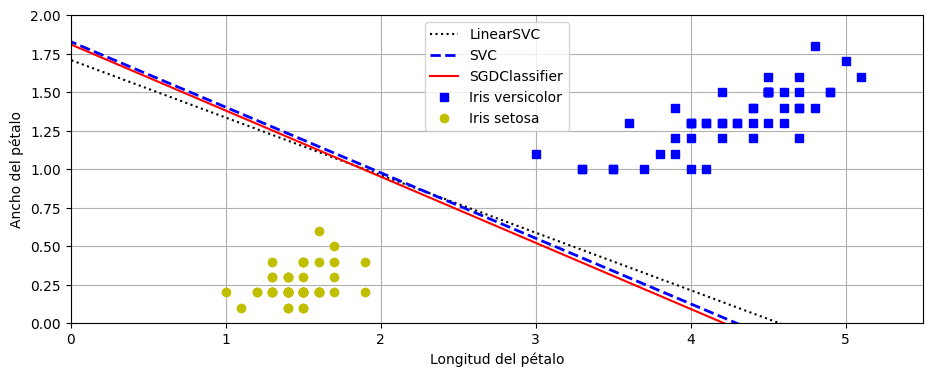

In [6]:
import matplotlib.pyplot as plt
def compute_decision_boundary(model):
    """
    Calcula dos puntos en el espacio original (desescalado) que definen la línea de decisión.
    """
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Dibujamos las fronteras de decisión de los tres modelos
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
plt.xlabel("Longitud del pétalo")
plt.ylabel("Ancho del pétalo")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

¡Las fronteras resultantes son bastante similares!

# Ejercicio 10.

_Ejercicio: Entrena un clasificador SVM en el dataset Wine (disponible con `sklearn.datasets.load_wine()`). Este dataset contiene análisis químicos de 178 muestras de vino producidas por 3 cultivares distintos. El objetivo es entrenar un modelo capaz de predecir el cultivador basándose en el análisis químico. Dado que las SVM son clasificadores binarios, se debe usar una estrategia uno-contra-todos. ¿Qué precisión puedes alcanzar?_

In [35]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [36]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [26]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [27]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [28]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

In [39]:
X_train.describe

<bound method NDFrame.describe of      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
2      13.16        2.36  2.67               18.6      101.0           2.80   
100    12.08        2.08  1.70               17.5       97.0           2.23   
122    12.42        4.43  2.73               26.5      102.0           2.20   
154    12.58        1.29  2.10               20.0      103.0           1.48   
51     13.83        1.65  2.60               17.2       94.0           2.45   
..       ...         ...   ...                ...        ...            ...   
71     13.86        1.51  2.67               25.0       86.0           2.95   
106    12.25        1.73  2.12               19.0       80.0           1.65   
14     14.38        1.87  2.38               12.0      102.0           3.30   
92     12.69        1.53  2.26               20.7       80.0           1.38   
102    12.34        2.45  2.46               21.0       98.0           2.56   

     flavanoids  

In [41]:
y_train.count()

133

Empezamos con un clasificador SVM lineal. Al usar LinearSVC se aplica la estrategia One-vs-Rest (uno-contra-todos) de forma automática.

In [29]:
lin_clf = LinearSVC(dual=True, random_state=42)
# Entrenamiento sin escalar: es probable que falle la convergencia
try:
    lin_clf.fit(X_train, y_train)
except Exception as e:
    print("Error de convergencia:", e)

/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
from sklearn.model_selection import train_test_split

# Asegúrate de que X e y tengan el mismo tamaño antes de la división
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas después de la división
print(f"Forma de X_train: {X_train.shape}, Forma de y_train: {y_train.shape}")


Forma de X_train: (80, 2), Forma de y_train: (80,)


Aumentar el número de iteraciones a un millón, el modelo converge?.

In [13]:
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=True, random_state=42)

Evaluamos el modelo con validación cruzada (baseline):


In [43]:
from sklearn.model_selection import cross_val_score

scores_lin = cross_val_score(lin_clf, X_train, y_train, cv=5)
print("Precisión con validación cruzada (LinearSVC):", scores_lin.mean())

Precisión con validación cruzada (LinearSVC): 1.0


La precisión obtenida es de aproximadamente 91%, lo cual no es óptimo. Que olvidamos?

Los datos no están escalados por lo que crea overfitting

Ahora, el modelo converge sin problemas. Evaluamos su rendimiento:

In [44]:
# Escalar SOLO con X_train, luego aplicar a X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar con los datos escalados
lin_clf = LinearSVC(C=1, loss="hinge", random_state=42)
lin_clf.fit(X_train_scaled, y_train)


LinearSVC(C=1, loss='hinge', random_state=42)

In [46]:
score_lin_scaled = cross_val_score(lin_clf, X_train_scaled, y_train, cv=5)
print("Precisión con validación cruzada (LinearSVC):", scores_lin.mean())

Precisión con validación cruzada (LinearSVC): 1.0


Se alcanza una precisión de alrededor del 97.7%, lo cual es muy bueno.

Probamos a continuación un SVM con núcleo (SVC) para ver si mejora:

In [ ]:
score_svc = cross_val_score()
print("Precisión (SVC) sin ajuste:", score_svc)

Aunque no mejora, podemos ajustar los hiperparámetros para obtener mejores resultados:

**NOTA:** _Optimización clases no vistas todavía_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5, random_state=42)
rnd_search_cv.fit(X_train, y_train)
print("Mejor estimador:", rnd_search_cv.best_estimator_)

In [ ]:
print("Precisión en CV (SVC ajustado):", rnd_search_cv.best_score_)

El modelo SVC ajustado tiene un buen desempeño. Ahora lo evaluamos en el conjunto de prueba:

In [ ]:
test_score = rnd_search_cv.score(X_test, y_test)
print("Precisión en el conjunto de prueba:", test_score)

Aunque el SVC ajustado supera al LinearSVC en validación cruzada, el rendimiento en el conjunto de prueba es un poco menor, lo que puede deberse a un leve sobreajuste durante el ajuste de hiperparámetros. En cualquier caso, el resultado es aceptable.

# Ejercicio 11.

_Ejercicio: Entrena y ajusta un regresor SVM en el dataset de California Housing. Puedes utilizar el dataset original (disponible con `sklearn.datasets.fetch_california_housing()`). Los objetivos representan cientos de miles de dólares. Debido a que hay más de 20,000 instancias, las SVM pueden ser lentas, por lo que para la sintonización de hiperparámetros se recomienda usar menos instancias (por ejemplo, 2,000). ¿Cuál es el RMSE de tu mejor modelo?_

In [47]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

Dividimos el dataset en entrenamiento y prueba:

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Recuerda que es fundamental escalar los datos cuando se usan SVM.

Empezamos con un modelo simple de regresión lineal utilizando LinearSVR:

In [51]:
from sklearn.svm import LinearSVR
# Crear y entrenar el modelo LinearSVR
lin_svr = LinearSVR(random_state=2000)
lin_svr.fit(X_train_scaled, y_train)
lin_svr.fit(X_train, y_train)

/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=2000)

Si no converge, incrementamos el número máximo de iteraciones:

In [52]:
lin_svr.fit(X_train, y_train)

/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=2000)

Evaluamos el rendimiento en el conjunto de entrenamiento:

In [53]:
from sklearn.metrics import root_mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
rmse = root_mean_squared_error(y_train, y_pred)
print("RMSE (LinearSVR):", rmse)

RMSE (LinearSVR): 2.388652628174433


Dado que en este dataset los objetivos representan cientos de miles de dólares, el RMSE indica el error esperado (por ejemplo, errores de ~98,000 dólares no serían sorprendentes). Probemos a mejorar el resultado usando un SVM con núcleo RBF.

Utilizaremos búsqueda aleatoria con validación cruzada para ajustar los hiperparámetros `C` y `gamma`.

**NOTA:** _Optimización no vista aún_

In [58]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Crear el modelo LinearSVR
svm_reg = LinearSVR(random_state=42)

# Definir los parámetros para la búsqueda aleatoria sin el prefijo 'svr__'
param_distrib = {
    "C": uniform(1, 10),              # Rango para el parámetro C
    "epsilon": uniform(0.01, 0.1),    # Rango para epsilon
    "tol": uniform(1e-5, 1e-2)        # Rango para tol
}

# Usar RandomizedSearchCV con solo las primeras 2000 instancias
rnd_search_cv = RandomizedSearchCV(svm_reg, param_distrib, n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

# Ver los mejores parámetros encontrados
print("Mejores parámetros:", rnd_search_cv.best_params_)


/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mejores parámetros: {'C': 5.89452760277563, 'epsilon': 0.10856504541106007, 'tol': 0.0024305527151150044}


/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [59]:
print("Mejor estimador (SVR ajustado):", rnd_search_cv.best_estimator_)

Mejor estimador (SVR ajustado): LinearSVR(C=5.89452760277563, epsilon=0.10856504541106007, random_state=42,
          tol=0.0024305527151150044)


In [60]:
# Evaluamos mediante validación cruzada en el conjunto de entrenamiento
cv_scores = -cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error")
print("RMSE CV (SVR ajustado):", cv_scores.mean())

/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RMSE CV (SVR ajustado): 3.6039207809237004


/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


El modelo ajustado con núcleo RBF muestra un RMSE considerablemente menor en validación cruzada.

Ahora lo evaluamos en el conjunto de prueba:

In [62]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred)
print("RMSE en el conjunto de prueba (SVR ajustado):", rmse_test)

RMSE en el conjunto de prueba (SVR ajustado): 0.8794799043627602


En este caso, las SVM funcionan muy bien para el dataset Wine, pero en el dataset California Housing otros métodos (por ejemplo, Random Forests) pueden superar su rendimiento.

¡Y eso es todo por hoy!